In [1]:
from QuditsOnQubits import create_ghz
from qiskit import qpy
from qiskit.circuit import QuantumCircuit

In [2]:
ghz_circ, ghz_state = create_ghz()

In [6]:
with open('Zgate.qpy', 'rb') as fd:
    Zgate = qpy.load(fd)[0]

with open('Xgate.qpy', 'rb') as fd:
    Xgate = qpy.load(fd)[0]

In [67]:
G1 = QuantumCircuit(6)

In [68]:
G1.append(Xgate, [0, 1])
G1.append(Zgate, [2, 3])
G1.append(Zgate, [4, 5])

In [12]:
G1G2 = QuantumCircuit(6)

G1G2.append(Xgate, [0, 1])
G1G2.append(Zgate, [0, 1])

G1G2.append(Xgate, [2, 3])
G1G2.append(Zgate, [2, 3])

G1G2.append(Xgate, [4, 5])
G1G2.append(Zgate, [4, 5])

In [13]:
G1G22 = QuantumCircuit(6)

G1G22.append(Xgate, [0, 1])
G1G22.append(Zgate, [0, 1])
G1G22.append(Zgate, [0, 1])

G1G22.append(Zgate, [2, 3])
G1G22.append(Xgate, [2, 3])
G1G22.append(Xgate, [2, 3])

G1G22.append(Zgate, [4, 5])
G1G22.append(Xgate, [4, 5])
G1G22.append(Xgate, [4, 5])

In [69]:
g1_circ = ghz_circ.copy()
g1_circ.append(G1, [0, 1, 2, 3, 4, 5])

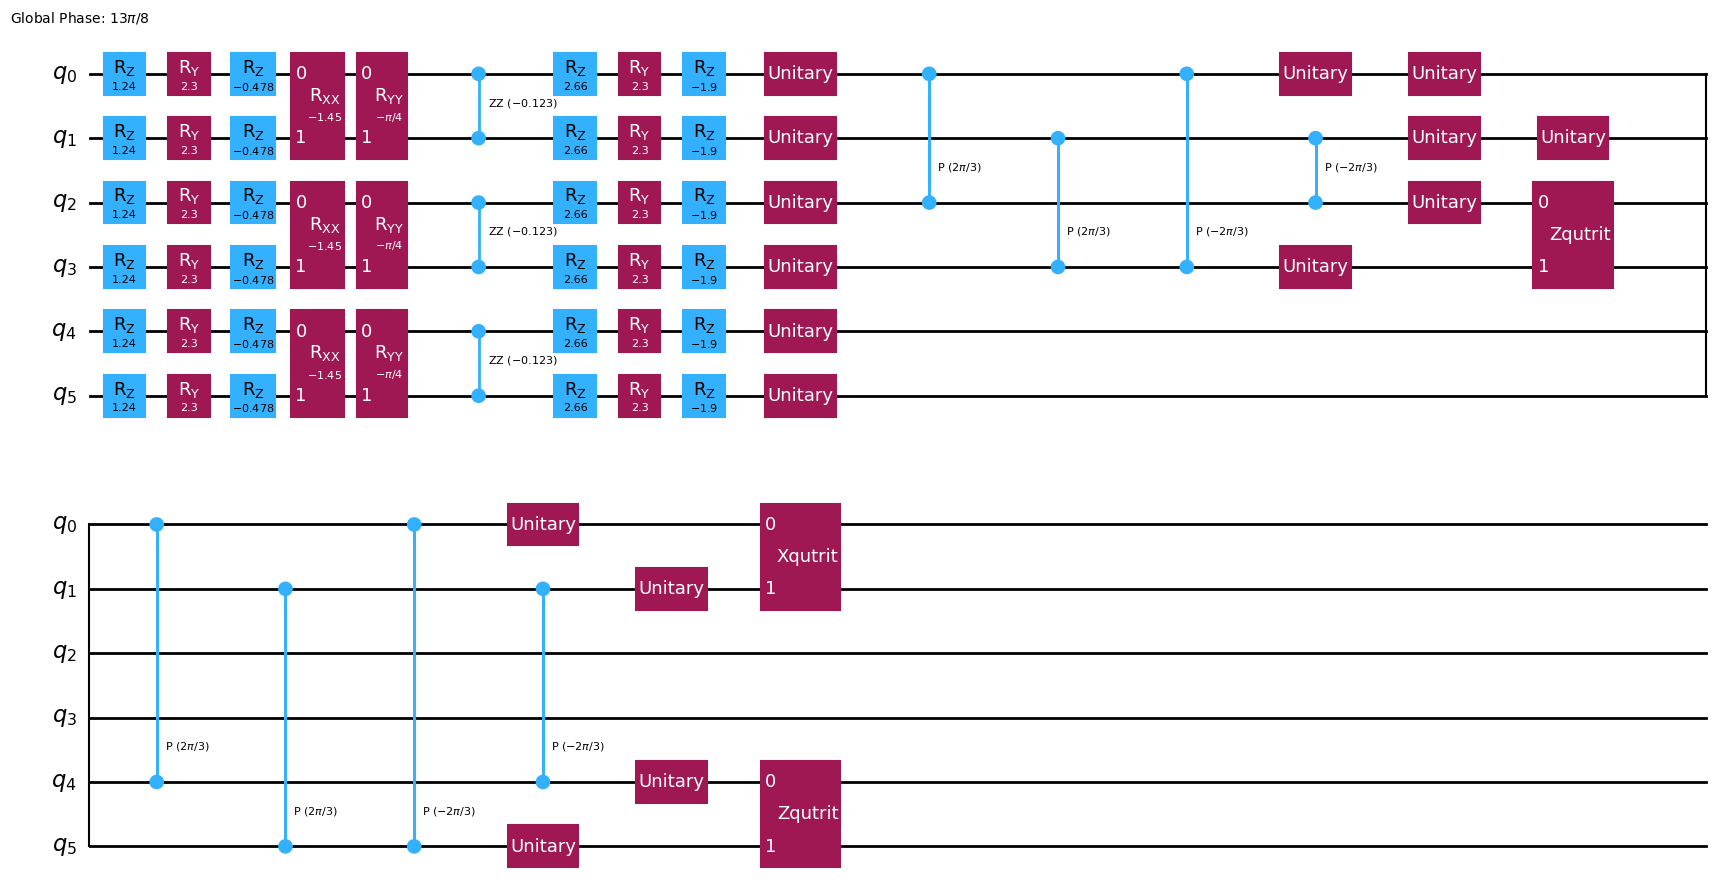

In [71]:
g1_circ.decompose().draw("mpl")

In [82]:
g1g2_circ = ghz_circ.copy()
g1g2_circ.append(G1G2, [0, 1, 2, 3, 4, 5])

In [83]:
g1g22_circ = ghz_circ.copy()
g1g22_circ.append(G1G22, [0, 1, 2, 3, 4, 5])

In [84]:
ghz_circs = [g1_circ, g1g2_circ, g1g22_circ]

In [44]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit_aer import AerSimulator
from qiskit.transpiler import generate_preset_pass_manager

In [45]:
pubs = [(ghz_circ[i], None, 1000) for i in range(3)]

In [46]:

sim_backend = AerSimulator()
pm = generate_preset_pass_manager(backend=sim_backend, optimization_level=1)

In [47]:
from qiskit.primitives import StatevectorSampler

In [48]:
sampler = StatevectorSampler()

In [49]:
job     = sampler.run(ghz_circs, shots=10000)

In [53]:
results = job.result()[0]

In [62]:
results.data

dict_items([('meas', BitArray(<shape=(), num_shots=10000, num_bits=6>))])

In [60]:
bitstrings = results.data.get_bitstrings()
print(bitstrings)

AttributeError: 'DataBin' object has no attribute 'get_bitstrings'

In [54]:
import numpy as np

In [63]:
from qiskit.quantum_info import Statevector

In [85]:
d2 = Statevector.from_instruction(ghz_circs[1]).probabilities_dict()

In [75]:
import matplotlib.pyplot as plt

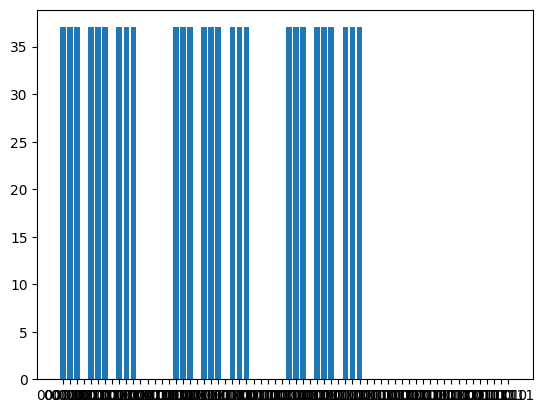

In [86]:
keys = np.array(list(d2.keys()))
vals = np.array(list(d2.values())) * 1000
plt.bar(keys, vals)
plt.show()

In [78]:
ω = np.exp(2j * np.pi / 3)

# mapa par bitów → qutryt
_mapping = {"00": 0, "01": 1, "10": 2}

def qutrit_sum(bitstr: str) -> int | None:
    """
    Zamienia każdą parę bitów na wartość qutrytu.
    Jeśli napotka parę spoza _mapping, zwraca None.
    """
    s = 0
    for i in range(0, len(bitstr), 2):
        pair = bitstr[i:i+2]
        if pair not in _mapping:
            return None
        s += _mapping[pair]
    return s

# d – Twój probabilities_dict(), np. d = Statevector.from_instruction(...).probabilities_dict()
def expectation_from_probs(d: dict[str, float]) -> float:
    E = 0+0j
    for bs, p in d.items():
        s = qutrit_sum(bs)
        if s is None:
            # pomijamy nie-kodowalne stany jak "11"
            continue
        E += p * (ω ** s)
    return E.real

In [87]:
e1 = expectation_from_probs(d2)

In [88]:
e1

np.float64(-8.326672684688674e-17)

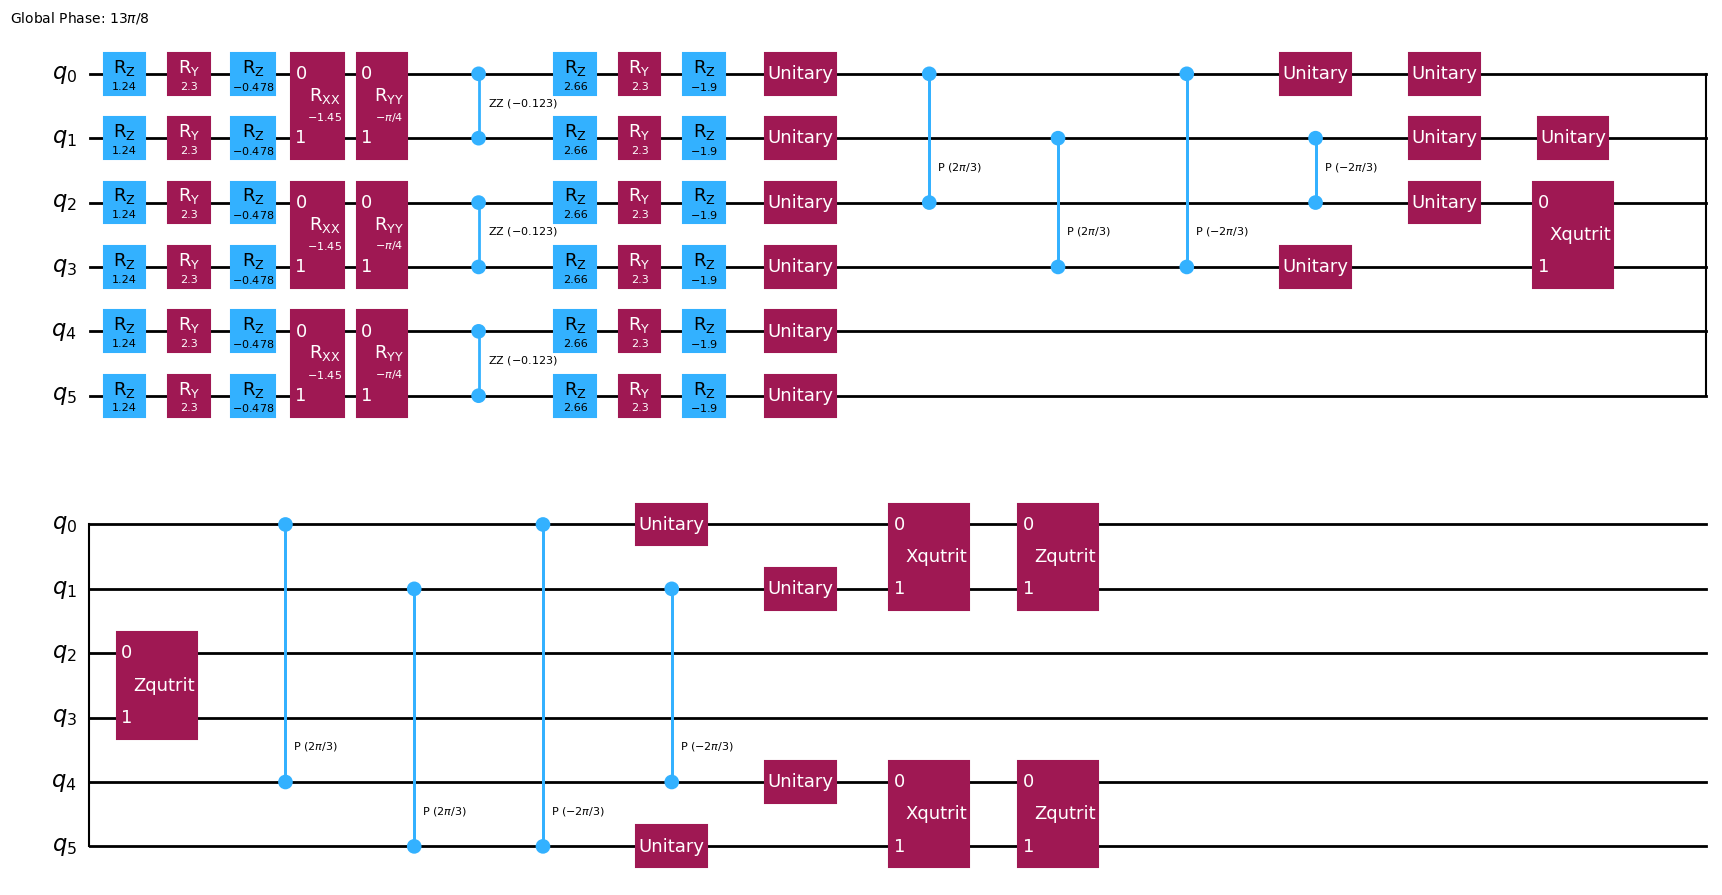

In [90]:
ghz_circs[1].decompose().draw("mpl")